# Notebook for plotting SWLLIP geochornology data in context of MCR dates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import pandas as pd

%matplotlib inline

## make python functions

In [14]:
def plot_dates(zircon_means, zircon_2sigmas, include, 
               sample_means, sample_2sigmas, colors, labels,
               legend=True, figsize=None, ylim=None, lineweight=None, 
               bbox_to_anchor=None, plot_zircons=True):
    """
    Make a date distribution plot.
    
    inputs:
    - zircon_means = list of numpy arrays containing mean dates (each array being a sample)
    - zircon_2sigmas = list of numpy arrays containing 2sigmas (each array being a sample)
    - include = list of 'yes' or 'no' array for inclusion in mean (each array being a sample)
    - sample_means = list of sample mean dates (one per sample)
    - sample_2sigmas = list of sample 2sigmas (one per sample)
    - colors = list of colors (one per sample)
    - labels = list of labels (one per sample)
    - figsize = figure size (optional)
    - ylim = ylim (optional)
    - linewidth = zircon linewidth (optional)
    - bbox_to_anchor = for the legend (optional)
    """
    # formatting constants
    zircon_spacing = 0.9
    sample_spacing = 5.75 - zircon_spacing
    start_x = 3
    yes_alpha = 0.8
    no_alpha = 0.2
    x_positions = []
    if lineweight==None:
        lineweight=3
    
    # initialize current x
    current_x = start_x
    
    # number of samples
    n_samples = len(zircon_means)
    
    # plot
    if figsize == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    if plot_zircons == False:
        for i in range(n_samples):
            sample_width = 20

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)
            
            current_x = current_x + 25
        
    if plot_zircons == True:
        # iterate over each sample
        for i in range(n_samples):

            # number of zircons in sample
            n_zircons = len(zircon_means[i])

            # sample width
            sample_width = zircon_spacing*n_zircons

            rectangle = matplotlib.patches.Rectangle((current_x-1, sample_means[i]-sample_2sigmas[i]),\
                                                     sample_width+1, sample_2sigmas[i]*2, color='lightgrey')
            ax.add_patch(rectangle)

            # the mean age

            ax.hlines(sample_means[i], current_x-1, current_x+sample_width)

            # legend control
            marked = False

            # iterate over each zircon
            for j in range(n_zircons):

                if marked:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha)
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)
                else:
                    if include[i][j] == 'yes':
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=yes_alpha, label=labels[i])
                        marked = True
                    else:
                        ax.vlines(current_x, zircon_means[i][j]-zircon_2sigmas[i][j], zircon_means[i][j]+zircon_2sigmas[i][j],\
                                  colors=colors[i], lw=lineweight, alpha=no_alpha)

                # tick the x to the next zircon
                current_x = current_x + zircon_spacing

            # tick the x to the next sample
            current_x = current_x + sample_spacing
            x_positions.append(current_x-sample_spacing)
    
    # prettify
    ax.invert_yaxis()
    ax.set_ylabel('$^{206}$Pb/$^{238}$U date (Ma)',fontsize=13)
    if legend == True:
        if bbox_to_anchor == None:
            ax.legend(bbox_to_anchor=(1.8,1), fontsize=12)
        else:
            ax.legend(bbox_to_anchor=bbox_to_anchor, fontsize=12)
    if ylim != None:
        ax.set_ylim(ylim)
        
    return fig, ax, x_positions

def read_data(header, nrows, path='../data/geochron/Swanson-Hysell2021a.xls'):
    return pd.read_excel(path, header=header,nrows=nrows,
                                        names=['zircon','Th_U','206Pb_mol','206Pb_mol%','Pb*/Pbc',
                                              'Pbc','206Pb/204Pb','','','','','','','','','','',
                                              '207Pb/206Pb_date','207Pb/206Pb_date_2sigma',
                                              '207Pb/235U_date','207Pb/235U_date_2sigma',
                                              '206Pb/238U_date','206Pb/238U_date_2sigma'])

def weighted_mean(dates,sigma):
    
    """
    calculated a weighted mean from dates and uncertainities
    
    input parameters
    ----------------
    dates: date of individual grains
    sigma: 1σ uncertainty associated with dates
    
    returns
    ----------------
    weighted_mean, 1σ uncertainty
    
    """
    
    inverse_variance=[]
    alpha=[]
    weighted_mean_calc=[]
    
    for n in range(0,len(dates)):
        value = 1/sigma[n]**2
        inverse_variance.append(value)
    inverse_variance_sum = np.sum(inverse_variance)
    
    for n in range(0,len(dates)):
        value = (1/sigma[n]**2)/inverse_variance_sum
        alpha.append(value)
        
    #calculate the weights for each date    
    for n in range(0,len(dates)):
        value = alpha[n]*dates[n]
        weighted_mean_calc.append(value)
    
    #take the sum of the weights multiplied by the dates to get the weighted
    #mean (equation 64 of McLean et al., 2011)
    weighted_mean = np.sum(weighted_mean_calc)
    
    #the variance of the weighted mean is simply the inverse of the sum of
    #the inverse variances of each date (equation 66 of McLean et al., 2011)
    variance = 1/inverse_variance_sum
    
    weighted_mean_sigma = np.sqrt(variance)
    
    n = len(dates)
    
    # print('The weighted mean is:')

    # print(weighted_mean)

    # print('With a 2sigma error of:')

    # print(weighted_mean_sigma)
    
    # print('N=' )
    # print(n)
    
    return weighted_mean, weighted_mean_sigma

## Import Duluth Complex geochronology and the upper southwest sequence of the North Shore Volcanic Group (7900 m thick)

Swanson-Hysell, N.L., Hoaglund, S.A., Crowley, J.L., Schmitz, M.D., Zhang, Y.*, and Miller Jr., J.D. (2021), **Rapid emplacement of massive Duluth Complex intrusions within the Midcontinent Rift**, *Geology*, doi:10.1130/G47873.1.

Swanson-Hysell, N.L., Ramenzani, J., Fairchild, L.M. and Rose, I., 2019, **Failed rifting and fast drifting: Midcontinent Rift development, Laurentia's rapid motion and the driver of Grenvillian orogenesis**, *Geological Society of America Bulletin*, doi:10.1130/B31944.1.

In [58]:
PRI = read_data(6, 6)
PRI['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes'])
PRI_mean, PRI_2sigma = weighted_mean(PRI['206Pb/238U_date'].tolist(),PRI['206Pb/238U_date_2sigma'].tolist())


# FC4b (Forest Center gabbroic anorthosite)
FC_4b = read_data(16, 8) 
FC_4b['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','no'])
FC_4b_filtered = FC_4b[FC_4b['include'] == 'yes']
FC4b_mean, FC4b_2sigma = weighted_mean(FC_4b_filtered['206Pb/238U_date'].tolist(),FC_4b_filtered['206Pb/238U_date_2sigma'].tolist())

# FC1 (Forest Center gabbroic anorthosite)
FC_1 = read_data(28, 10) 
FC_1['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes','yes','yes','yes','yes','yes'])
FC1_mean, FC1_2sigma = weighted_mean(FC_1['206Pb/238U_date'].tolist(),FC_1['206Pb/238U_date_2sigma'].tolist())

# BEI (Bald Eagle intrusion olivine gabbro)
BEI = read_data(42, 6) 
BEI['include'] = pd.Series(data=['yes','yes','yes','yes','yes','yes'])
BEI_mean, BEI_2sigma = weighted_mean(BEI['206Pb/238U_date'].tolist(),BEI['206Pb/238U_date_2sigma'].tolist())

# HCT Houghtaling Creek troctolite augite troctolite
HCT = read_data(52, 11) 
HCT['include'] = pd.Series(data=['yes','yes','yes','yes','no','no','no','no','no','no','no'])
HCT_filtered = HCT[HCT['include'] == 'yes']
HCT_mean, HCT_2sigma = weighted_mean(HCT_filtered['206Pb/238U_date'].tolist(),HCT_filtered['206Pb/238U_date_2sigma'].tolist())


CA-ID-TIMS data from Midcontinent Rift volcanics were published in Fairchild et al. 2017 and Swanson-Hysell et al. 2019

Fairchild, L. M., Swanson-Hysell, N. L., Ramezani, J., Sprain, C. J., and Bowring, S. A., 2017, The end of Midcontinent Rift magmatism and the paleogeography of Laurentia: Lithosphere, vol. 9, pp. 117–133, doi:10.1130/L580.1.

Swanson-Hysell, N. L., Ramezani, J., Fairchild, L. M., and Rose, I. R., 2019, Failed rifting and fast drifting: Midcontinent Rift development, Laurentia’s rapid motion and the driver of Grenvillian orogenesis: GSA Bulletin, doi:10.1130/b31944.1.

In [59]:
AS3 = pd.read_csv('../data/geochron/AS3_dates.csv')
AS3.sort_values('206Pb/238U', inplace=True, ascending=False)
AS3.reset_index(inplace=True)
AS3_mean, AS3_2sigma = weighted_mean(AS3['206Pb/238U_date'].tolist(),AS3['206Pb/238U_date_2sigma'].tolist())

NSVG_40I = pd.read_csv('../data/geochron/NSVG-40I_dates.csv')
NSVG_40I.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_40I.reset_index(inplace=True)
NSVG_40I_mean, NSVG_40I_2sigma = weighted_mean(NSVG_40I['206Pb/238U'].tolist(), NSVG_40I['206Pb/238U_2sigma'].tolist())

NSVG_TH1 = pd.read_csv('../data/geochron/NSVG-TH1_dates.csv')
NSVG_TH1.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_TH1.reset_index(inplace=True)
NSVG_TH1_mean, NSVG_TH1_2sigma = weighted_mean(NSVG_TH1['206Pb/238U'].tolist(), NSVG_TH1['206Pb/238U_2sigma'].tolist())

NSVG_PR = pd.read_csv('../data/geochron/NSVG-PR_dates.csv')
NSVG_PR.sort_values('206Pb/238U', inplace=True, ascending=False)
NSVG_PR.reset_index(inplace=True)
NSVG_PR_mean, NSVG_PR_2sigma = weighted_mean(NSVG_PR['206Pb/238U'].tolist(), NSVG_PR['206Pb/238U_2sigma'].tolist())

In [60]:
U_Pb_zircon_dates = [NSVG_40I['206Pb/238U'].tolist(),
                    NSVG_TH1['206Pb/238U'].tolist(),
                    NSVG_PR['206Pb/238U'].tolist(),
                    AS3['206Pb/238U_date'].tolist(),
                    PRI['206Pb/238U_date'].tolist(),
                    BEI['206Pb/238U_date'].tolist(),
                    FC_1['206Pb/238U_date'].tolist(),
                    FC_4b['206Pb/238U_date'].tolist(),
                    HCT['206Pb/238U_date'].tolist()]

U_Pb_zircon_2sigmas = [NSVG_40I['206Pb/238U_2sigma'].tolist(),
                      NSVG_TH1['206Pb/238U_2sigma'].tolist(),
                      NSVG_PR['206Pb/238U_2sigma'].tolist(),
                      AS3['206Pb/238U_date_2sigma'].tolist(),
                      PRI['206Pb/238U_date_2sigma'].tolist(),
                      BEI['206Pb/238U_date_2sigma'].tolist(),
                      FC_1['206Pb/238U_date_2sigma'].tolist(),
                      FC_4b['206Pb/238U_date_2sigma'].tolist(),
                      HCT['206Pb/238U_date_2sigma'].tolist()]

U_Pb_zircon_include = [NSVG_40I['include'].tolist(),
                       NSVG_TH1['include'].tolist(),
                       NSVG_PR['include'].tolist(),
                       AS3['include'].tolist(),
                       PRI['include'].tolist(),
                       BEI['include'].tolist(),
                       FC_1['include'].tolist(),
                       FC_4b['include'].tolist(),
                       HCT['include'].tolist()]
U_Pb_sample_means = [NSVG_40I_mean,
                     NSVG_TH1_mean, 
                     NSVG_PR_mean,
                     AS3_mean,
                     PRI_mean,
                     BEI_mean,
                     FC1_mean,
                     FC4b_mean,
                     HCT_mean]

U_Pb_sample_2sigmas = [NSVG_40I_2sigma,
                       NSVG_TH1_2sigma, 
                       NSVG_PR_2sigma, 
                       AS3_2sigma,
                       PRI_2sigma,
                       BEI_2sigma,
                       FC1_2sigma,
                       FC4b_2sigma,
                       HCT_2sigma]

colors = ['blue',
          'blue',
          'blue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue',
          'darkblue']

labels = ['40th Ave Icelandite',
          'Two Harbors Icelandite',
          'Palisade Rhyolite',
          'Partridge River intrusion',
          'Bald Eagle intrusion',
          'Duluth area anorthositic series (AS3)',
          'Forest Center anorthositic series (FC-1)',
          'Forest Center anorthositic series (FC-4b)',
          'Houghtaling Creek troctolite']

In [61]:
MCR_geochron = pd.DataFrame({'labels': labels, 
                      'polarity_colors' : colors, 
                      'U_Pb_zircon_dates': U_Pb_zircon_dates, 
                      'U_Pb_zircon_2sigmas': U_Pb_zircon_2sigmas,
                      'U_Pb_zircon_include': U_Pb_zircon_include,
                      'U_Pb_sample_mean': U_Pb_sample_means,
                      'U_Pb_sample_2sigma': U_Pb_sample_2sigmas})

# MCR_geochron.to_csv('./code_output/compiled_geochron.csv')
# geochron_data = pd.read_csv('./code_output/compiled_geochron.csv')
geochron_data = MCR_geochron
geochron_data

,labels,polarity_colors,U_Pb_zircon_dates,U_Pb_zircon_2sigmas,U_Pb_zircon_include,U_Pb_sample_mean,U_Pb_sample_2sigma
0,40th Ave Icelandite,blue,"[1098.58, 1097.46, 1097.18, 1096.88, 1096.81, ...","[2.72, 0.73, 0.95, 0.7, 0.8, 0.67, 0.64, 0.99]","[no, yes, yes, yes, yes, yes, yes, yes]",1096.768836,0.283839
1,Two Harbors Icelandite,blue,"[1097.33, 1096.44, 1096.27, 1096.08, 1095.74]","[0.71, 0.57, 0.59, 0.7, 0.71]","[no, yes, yes, yes, yes]",1096.369245,0.289171
2,Palisade Rhyolite,blue,"[1096.29, 1094.66, 1094.47, 1094.34, 1094.19, ...","[1.53, 0.69, 0.77, 0.7, 1.14, 1.09, 0.87, 0.49]","[no, yes, yes, yes, yes, yes, yes, yes]",1094.015606,0.273667
3,Partridge River intrusion,darkblue,"[1096.23, 1096.09, 1095.97, 1095.94, 1095.8, 1...","[0.88, 0.58, 0.5, 0.49, 0.49, 0.49, 0.46, 0.57]","[yes, yes, yes, yes, yes, yes, yes, yes]",1095.862213,0.187112
4,Bald Eagle intrusion,darkblue,"[1096.3692956957627, 1096.3411986087767, 1096....","[0.4540650746678668, 0.44939847012038203, 0.45...","[yes, yes, yes, yes, yes, yes]",1096.194915,0.188294
5,Duluth area anorthositic series (AS3),darkblue,"[1096.1747761266788, 1096.0388091332786, 1095....","[0.4484241145264616, 0.45859332803922687, 0.48...","[yes, yes, yes, yes, yes, yes]",1095.884576,0.190780
6,Forest Center anorthositic series (FC-1),darkblue,"[1096.2692620731762, 1096.190625997245, 1095.9...","[0.5108447698370121, 0.5053458354644664, 0.509...","[yes, yes, yes, yes, yes, yes, yes, yes, yes, ...",1095.806484,0.158034
7,Forest Center anorthositic series (FC-4b),darkblue,"[1095.8461922193035, 1095.8358206391165, 1095....","[0.46875239873114355, 0.4659085093712412, 0.47...","[yes, yes, yes, yes, yes, yes, yes, no]",1095.689963,0.178937
8,Houghtaling Creek troctolite,darkblue,"[1095.664310374369, 1095.613548461745, 1095.29...","[0.4670155927134175, 0.5158799382054571, 0.602...","[yes, yes, yes, yes, no, no, no, no, no, no, no]",1095.437962,0.258533


## Load geochronology data from Mohr et al., 2023

In [62]:
Mohr2023a_data = pd.read_csv('../data/geochron/Mohr2023_geochron.csv')
Mohr2023a_data = Mohr2023a_data.sort_values(by=['206Pb/238U age (Ma)']).reset_index(drop=True)
Mohr2023a_data

,sample,location,description,latitude,longitude,206Pb/238U age (Ma),2_sigma,MSWD,n
0,MM21-R52-CB3Z,"Grand Canyon rm. 52, N AZ",Collected from a pegmatoidal interior of a 57 ...,36.28344,-111.89260,1082.18,1.25,0.09,4
1,MM2021-CA1,"Dead Mountains, SE CA",Collected from a felsic zone within subophitic...,35.08636,-114.75425,1082.60,0.30,1.53,8
2,F2020-5,"Panamint Mountains, CA",Collected from a ~20 cm wide felsic segregatio...,35.96230,-116.90123,1097.91,0.29,0.79,8
3,JT19-AA-01,"Salt River Canyon, central AZ",Collected from a ~10 cm wide portion of a subp...,33.80767,-110.47423,1097.97,0.12,1.54,13
4,CS-7-GEOCHRON,"Ibex Range, SE CA",Collected from a ~5 cm thick coarse-grained fe...,35.81503,-116.38968,1098.09,0.91,1.57,4
5,K12-132L,"Grand Canyon, rm. 132, N AZ",Collected from a 20 cm wide granophyre segrega...,36.35093,-112.45621,1098.09,0.34,1.53,9
6,MS17-107-01,"Grand Canyon, rm. 107, N AZ",Collected from a 20 cm wide granophyre pod nea...,36.23335,-112.33145,1098.16,0.59,0.67,4
7,CS-4-GEOCHRON,"Panamint Mountains, CA",Collected from a 5 cm thick medium-grained fel...,35.96244,-116.88572,1098.27,0.27,0.35,9


### using Monte Carlo resample to estiamte the duration of the ca. 1098 Ma SWLLIP mafic magmatism

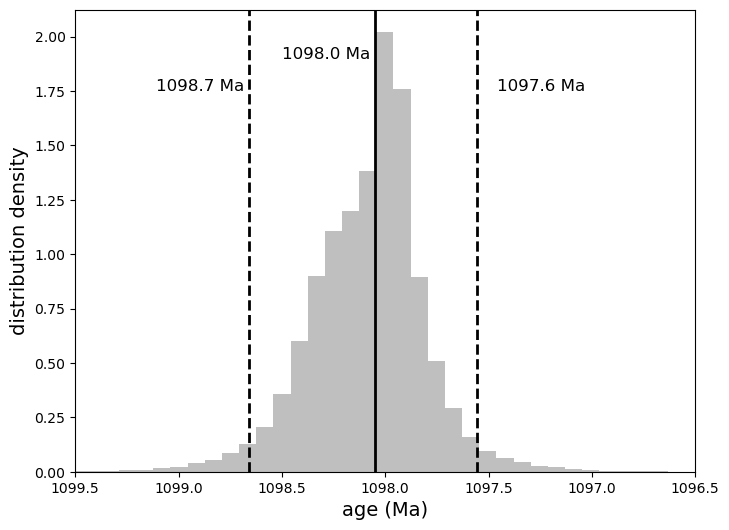

In [113]:
resampled_ages = np.array([])
n_resample = 10000

mafic_sill_dates = Mohr2023a_data[Mohr2023a_data['sample'].str.contains('F2020-5|JT19-AA-01|CS-7-GEOCHRON|K12-132L|MS17-107-01|CS-4-GEOCHRON')].reset_index(drop=True)
# mafic_sill_dates
for age, sigma in zip(mafic_sill_dates['206Pb/238U age (Ma)'], mafic_sill_dates['2_sigma']/2):
    # print(age, sigma)
    resampled_ages = np.append(resampled_ages, np.random.normal(age, sigma, n_resample))

lower = np.percentile(resampled_ages, 2.5)
upper = np.percentile(resampled_ages, 97.5)
median = np.median(resampled_ages)

plt.figure(figsize=(8,6))
plt.hist(resampled_ages, bins=50, density=True, color='grey', alpha=0.5)
plt.xlim(1099.5, 1096.5)
plt.axvline(lower, color='black', linestyle='--', linewidth=2)
plt.axvline(upper, color='black', linestyle='--', linewidth=2)
plt.axvline(median, color='black', linestyle='-', linewidth=2)
plt.text(lower-0.1, 1.75, str(round(lower,1))+' Ma', fontsize=12)
plt.text(upper+0.45, 1.75, str(round(upper,1))+' Ma', fontsize=12)
plt.text(median+0.45, 1.9, str(round(median,1))+' Ma', fontsize=12)


plt.xlabel('age (Ma)', fontsize=14)
plt.ylabel('distribution density', fontsize=14)
plt.savefig('../figure/SWLLIP_duration.pdf', bbox_inches='tight')
plt.show()

## Generate geochronology figure for manuscript

Text(0, 0.5, '$^{206}$Pb/$^{238}$U date (Ma)')

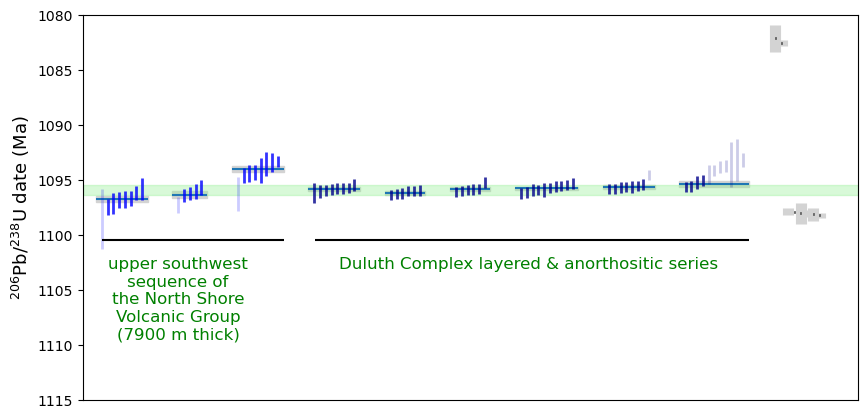

In [82]:
sample_width = 1

fig, ax, x_positions = plot_dates(MCR_geochron.U_Pb_zircon_dates, MCR_geochron.U_Pb_zircon_2sigmas, 
                                  MCR_geochron.U_Pb_zircon_include, 
                                  MCR_geochron.U_Pb_sample_mean, MCR_geochron.U_Pb_sample_2sigma, 
                                  colors, labels, legend=False, figsize=(10,5), lineweight=2)

# add Duluth Complex duration bar
rectangle = matplotlib.patches.Rectangle((0,1095.71 - 0.17),300, (1096.19 + 0.19)-(1095.71 - 0.17), color='lightgreen',alpha=0.35)
ax.add_patch(rectangle)

# add SWLLIP duration bar
rectangle = matplotlib.patches.Rectangle((0,1095.71 - 0.17),300, (1096.19 + 0.19)-(1095.71 - 0.17), color='lightgreen',alpha=0.35)
ax.add_patch(rectangle)

plt.text(100, 1102, 'Duluth Complex layered & anorthositic series', color='green' ,fontsize=12,
        verticalalignment='top',horizontalalignment='right')
plt.hlines(1100.5,x_positions[2]+5,x_positions[8], color='k')

plt.text(15,1102,'upper southwest\nsequence of\nthe North Shore\nVolcanic Group\n(7900 m thick)',verticalalignment='top',
         horizontalalignment='center',fontsize=12, color='green')
plt.hlines(1100.5,3,x_positions[2], color='k')


for i in range(len(Mohr2023a_data)):
    current_x = (i+5+int(x_positions[-1]))
    this_mean_age = Mohr2023a_data['206Pb/238U age (Ma)'][i]
    this_2_sigma = Mohr2023a_data['2_sigma'][i]
    this_age_lower = this_mean_age - this_2_sigma
    this_age_upper = this_mean_age + this_2_sigma
    this_n = Mohr2023a_data['n'][i]


    plt.gca().vlines(current_x, this_mean_age-this_2_sigma, this_mean_age+this_2_sigma, color='lightgrey', lw=8)

    plt.gca().hlines(this_mean_age, xmin = current_x-.05, xmax = current_x+.05, color='k', lw=2)

    plt.axhline(this_mean_age, current_x-1, current_x+sample_width)

plt.xlim(0, int(x_positions[-1])+len(Mohr2023a_data)+10)
plt.xticks([])
plt.ylim(1115, 1080)
# plt.gca().invert_yaxis()
plt.ylabel('$^{206}$Pb/$^{238}$U date (Ma)',fontsize=13)